In [1]:
from lbmpy.session import *
from lbmpy.cumulants import *
from lbmpy.moments import *
from lbmpy.continuous_distribution_measures import continuous_moment
from lbmpy.stencils import LBStencil

# Demo: Moments, Cumulants and Maxwellian Equilibrium

## 1) Moments & Cumulants


### Moments

The *moments* and *cumulants* modules contain functions to calculate moments and cumulants of functions on a discrete velocity space defined by a stencil. 

In [2]:
stencil = LBStencil(Stencil.D2Q9)
pdfs = sp.symbols("f:9")
pdfs

Discrete moments are computed by following formula:

$$ \sum_{d \in S} d_1^{m_1} d_2^{m_2} \; f_d  $$ 

with $S$ being the stencil, $d_i$ the direction components, $f_d$ the function values for each direction and $m_j$ the components of the moment tuple.

Lets compute the first moment in the first direction, i.e. $(m_1, m_2) = (1,0)$.

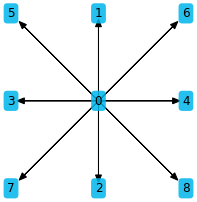

In [3]:
plt.figure(figsize=(3, 3))
stencil.plot()

In [4]:
discrete_moment(pdfs, (1, 0), stencil)

We get contributions of all directions that have a non-zero x-component, weighted with the sign of the direction. 

For the second order moment, the direction components are squared, so all contributions come in with a positive sign.

In [5]:
discrete_moment(pdfs, (2, 0), stencil)

We can specify the moments not only as exponent tuples but also as polynomials in the $d_i$'s. 
The symbols for the $d_i$ are provided by the *moments* module as ``MOMENT_SYMBOLS``

In [6]:
x, y, z = MOMENT_SYMBOLS
discrete_moment(pdfs, x, stencil)

The same works also for sums:

In [7]:
discrete_moment(pdfs, x**2 * y + y**2, stencil)

Here the advantage of the polynomial representation becomes visible. 
To compute the same moment with exponent tuples takes two calls:

In [8]:
discrete_moment(pdfs, (2, 1), stencil) + discrete_moment(pdfs, (0, 2), stencil)

### Cumulants

Cumulants are an alternative to the moment represenation, see the [Wikipedia article](https://en.wikipedia.org/wiki/Cumulant). Cumulants can be calculated directly using the cumulant generating function, or can be calculated by moments.

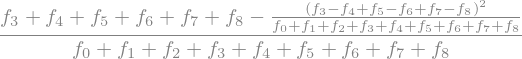

In [9]:
discrete_cumulant(pdfs, (2, 0), stencil)

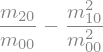

In [10]:
cumulant_as_function_of_raw_moments((2,0))

In [11]:
raw_moment_as_function_of_cumulants((2,0))

## 2) Using Moments to derive discrete LBM equilibrium

For full stencils i.e. *D2Q9* and *D3Q27* a LBM equilibrium can be derived using the following strategy:

- calculate all moments or cumulants up to second order of the continuous Maxwell-Boltzmann distribution
- for full stencils there are as many moments/cumulants as stencil directions, so we can determine the pdf values from them

First we obtain the continuous Maxwellian equilibrium as *sympy* expression. We fix the speed of sound to $\frac{1}{3}$

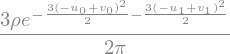

In [12]:
from lbmpy.maxwellian_equilibrium import continuous_maxwellian_equilibrium, discrete_maxwellian_equilibrium

dim = len(stencil[0])
maxwellian = continuous_maxwellian_equilibrium(dim=dim, c_s_sq=sp.Rational(1,3))
maxwellian

Then we get all moment exponent tuples up to order 2 and calculate these moments of the continuous Maxwellian equilibrium:

In [13]:
moments = moments_up_to_component_order(2, dim=dim)
moments

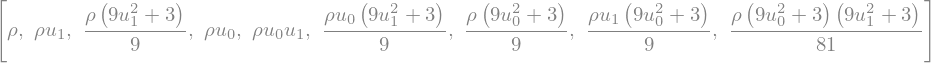

In [14]:
cont_eq_moments = [continuous_moment(maxwellian, m, sp.symbols("v_:2")[:dim]) for m in moments]
cont_eq_moments

To obtain the same equilibrium as in the LBM literature, we have to drop all terms that have order 3 or higher:

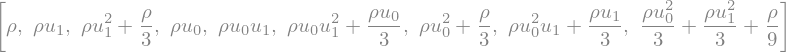

In [15]:
cont_eq_moments = [remove_higher_order_terms(m, order=3, symbols=sp.symbols("u_:3")) 
                   for m in cont_eq_moments]
cont_eq_moments

Then we take these equilibrium moments and determine pdf values, which would lead to these moment values.
The moment matrix transforms pdfs into moment space. To obtain the equilibrium pdfs we only have to transform the equilibrium moments with the inverse of this matrix:

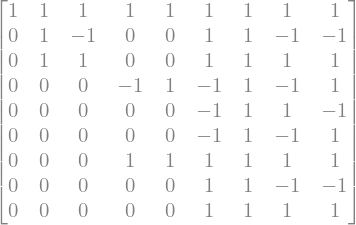

In [16]:
M = moment_matrix(moments, stencil)
M

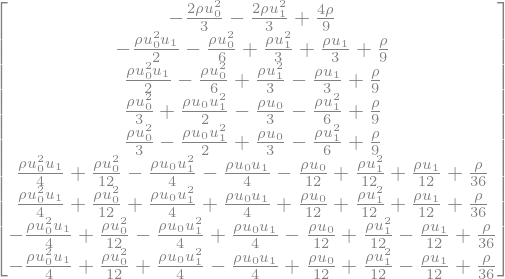

In [17]:
derived_eq = M.inv() * sp.Matrix(cont_eq_moments)
derived_eq

This is the same as the standard discrete equilibrium found in LBM literature.

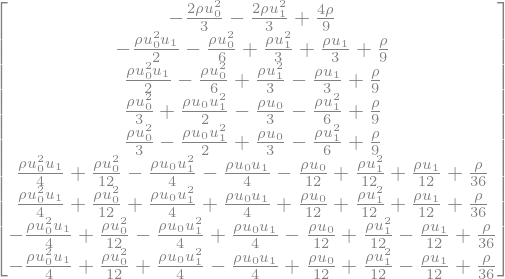

In [18]:
literature_version = sp.Matrix(discrete_maxwellian_equilibrium(stencil, c_s_sq=sp.Rational(1,3), order=3))
literature_version

## 3) Reduced Stencils

This method for deriving a discrete equilibrium works well for "full stencils" i.e. with $3^d$ directions, where $d$ is the dimension.

In [19]:
import pytest
pytest.importorskip('ipy_table')

<module 'ipy_table' from '/home/markus/miniconda3/envs/pystencils/lib/python3.8/site-packages/ipy_table/__init__.py'>

In [20]:
moment_equality_table(LBStencil(Stencil.D2Q9), truncate_order=2)

Matched moments 13 - non matched moments 2 - total 15


order,,,
0,"(0, 0) x 1",,
1,"(1, 0) x 2",,
2,"(1, 1) x 1","(2, 0) x 2",
3,"(2, 1) x 2","(3, 0) x 2",
4,"(2, 2) x 1","(3, 1) x 2","(4, 0) x 2"


In [21]:
moment_equality_table(LBStencil(Stencil.D3Q19), truncate_order=2)

Matched moments 26 - non matched moments 9 - total 35


order,,,,
0,"(0, 0, 0) x 1",,,
1,"(1, 0, 0) x 3",,,
2,"(1, 1, 0) x 3","(2, 0, 0) x 3",,
3,"(1, 1, 1) x 1","(2, 1, 0) x 6","(3, 0, 0) x 3",
4,"(2, 1, 1) x 3","(2, 2, 0) x 3","(3, 1, 0) x 6","(4, 0, 0) x 3"


In [22]:
moment_equality_table(LBStencil(Stencil.D3Q19), truncate_order=2)

Matched moments 26 - non matched moments 9 - total 35


order,,,,
0,"(0, 0, 0) x 1",,,
1,"(1, 0, 0) x 3",,,
2,"(1, 1, 0) x 3","(2, 0, 0) x 3",,
3,"(1, 1, 1) x 1","(2, 1, 0) x 6","(3, 0, 0) x 3",
4,"(2, 1, 1) x 3","(2, 2, 0) x 3","(3, 1, 0) x 6","(4, 0, 0) x 3"
